In [1]:
import torch
from tqdm import tqdm
import numpy as np
from utils import calculate_bleu_scores, load_checkpoint
from dataset import ImageCaptioningDataset
from torch.utils.data import DataLoader
from torchvision.models import ResNet101_Weights
from models import *
import os
import pickle
import matplotlib.pyplot as plt

/Users/youssefshaarawy/venvs/IC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
def evaluate(encoder, decoder, dataloader, batches=None):
    encoder.eval()
    decoder.eval()
    all_ground_truths_captions = []
    decoded_sentences = []
    all_images = []
    bleu_4_scores = []
    with torch.no_grad():
        for i, (image_tensor, tokenized_caption, caption_texts) in enumerate(tqdm(dataloader)):
            if batches and i >= batches:
                break
            all_images.extend(image_tensor)
            encoder_outputs = encoder(image_tensor.to(device))
            decoder_outputs, decoder_hidden, _ = decoder(
                encoder_outputs)

            if decoder_outputs.ndim == 3:
                _, topi = decoder_outputs.topk(1)
                decoded_ids = topi.squeeze()
            else:
                decoded_ids = decoder_outputs
            for index, decoded_sentence in enumerate(decoded_ids):
                sentence = dataloader.dataset.tokens_to_sentence(
                    decoded_sentence)
                decoded_sentences.append(sentence)
                ground_truths = np.array(caption_texts)[:, index]
                split_captions = [caption.split(' ')
                                  for caption in ground_truths]
                all_ground_truths_captions.append(
                    split_captions)
                bleu_4 = calculate_bleu_scores(decoded_sentences[-1:][:1],
                                               all_ground_truths_captions[-1:][:1])
                bleu_4_scores.append(bleu_4)

    # images = {}
    # for i in range(1, 4):
    #     plot_image = image_tensor[-i].permute(1, 2, 0).numpy()
    #     image_captions = [' '.join(cap)
    #                       for cap in all_ground_truths_captions[-i]]
    #     image_predicted_captions = ' '.join(decoded_sentences[-i])
    #     bleu_scores = calculate_bleu_scores(decoded_sentences[-i:][:1],
    #                                         all_ground_truths_captions[-i:][:1])
    #     images[f'test_image_{i}'] = wandb.Image(plot_image, caption=f'prediction: {image_predicted_captions}\n'
    #                                             f'ground truth: {image_captions}\n'
    #                                             f'bleu scores: {bleu_scores}')

    # bleu_1, bleu_2, bleu_3, bleu_4 = calculate_bleu_scores(
    #     decoded_sentences, all_ground_truths_captions)

    return all_images, decoded_sentences, all_ground_truths_captions, bleu_4_scores


def display_image(image, decoded_sentence, ground_truth, bleu):
    text = '\n'.join([' '.join(c) for c in ground_truth])
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(
        f'Prediction: {" ".join(decoded_sentence)}\nGround truth: {text}\nbleu-4={bleu[3]}')
    # plt.text(10, -20, text, fontsize=12, color='white', va='top', wrap=True,
    #          bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.5'))
    plt.show()

In [4]:
dataset_settings = {
    'root_dir': '/Users/youssefshaarawy/Documents/Datasets/INM706/flickr30k_images',
    'caption_file': 'results.csv',
    'image_folder': 'flickr30k_images',
    'max_length': 20
}

dataloader_settings = {
    'batch_size': 32,
    'shuffle': True,
    'pin_memory': True
}

In [5]:
if os.path.exists('lang.pickle'):
    os.remove('lang.pickle')
test_dataset = ImageCaptioningDataset(
    **dataset_settings, stage='test', transforms=ResNet101_Weights.DEFAULT.transforms())
test_dataloader = DataLoader(
    test_dataset, **dataloader_settings)

Loaded 6357 test images


In [6]:
test_dataset_modified = ImageCaptioningDataset(
    **dataset_settings, stage='test', transforms=ResNet101_Weights.DEFAULT.transforms())
with open("modified_lang.pickle", "rb") as input_file:
    test_dataset_modified.lang = pickle.load(input_file)
test_dataloader_modified = DataLoader(
    test_dataset_modified, **dataloader_settings)

Loaded 6357 test images


In [7]:
model_settings = {
    'hidden_size': 512
}
decoder_settings = {
    'max_length': 20,
    'embedding_size': 512,
    'dropout_p': 0.2
}
encoder_settings = {
    'freeze_backbone': False
}
encoder = ImageEncoderFC(
    **model_settings, **encoder_settings)
decoder = VanillaDecoderRNN(**model_settings, **decoder_settings,
                            output_size=test_dataset_modified.lang.n_words, device=device)

load_checkpoint(encoder, decoder, None, None,
                os.path.join('weights', 'ImageEncoderFC_VanillaDecoderRNN_ckpt_4.pth'))
encoder = encoder.to(device)
decoder = decoder.to(device)
all_images, decoded_sentences, all_ground_truths_captions, bleu_scores = evaluate(
    encoder, decoder, test_dataloader_modified, 10)

Loaded checkpoint from epoch 4


  5%|▌         | 10/199 [00:06<02:05,  1.50it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


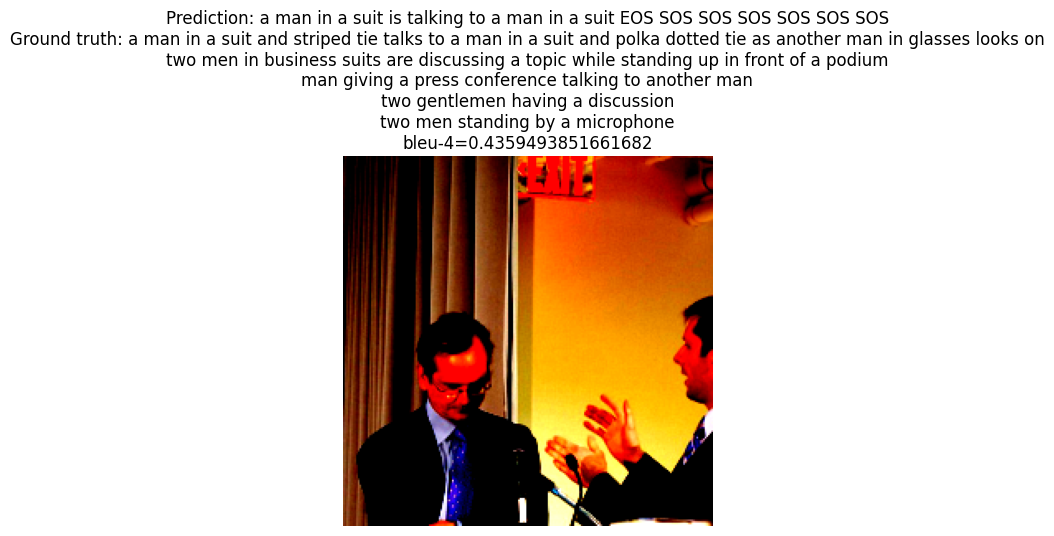

In [8]:
for image, decoded_sentence, ground_truth, bleu in sorted(zip(all_images, decoded_sentences, all_ground_truths_captions, bleu_scores), key=lambda x: x[3][3], reverse=True):
    display_image(image, decoded_sentence, ground_truth, bleu)
    break

In [9]:
model_settings = {
    'hidden_size': 512
}
decoder_settings = {
    'max_length': 20,
    'embedding_size': 512,
    'dropout_p': 0.2,
    'attention_type': 'None'
}
encoder_settings = {
    'freeze_backbone': False
}
encoder = ImageEncoderAttention(
    **model_settings, **encoder_settings).to(device)
decoder = DecoderWithAttention(**model_settings, **decoder_settings,
                               output_size=test_dataset_modified.lang.n_words, device=device, encoder_dim=encoder.out_features).to(device)

load_checkpoint(encoder, decoder, None, None,
                os.path.join('weights', 'ImageEncoderAttention_DecoderWithAttention_ckpt_1.pth'))
encoder = encoder.to(device)
decoder = decoder.to(device)
all_images, decoded_sentences, all_ground_truths_captions, bleu_scores = evaluate(
    encoder, decoder, test_dataloader_modified, 10)

Loaded checkpoint from epoch 1


  5%|▌         | 10/199 [00:07<02:26,  1.29it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


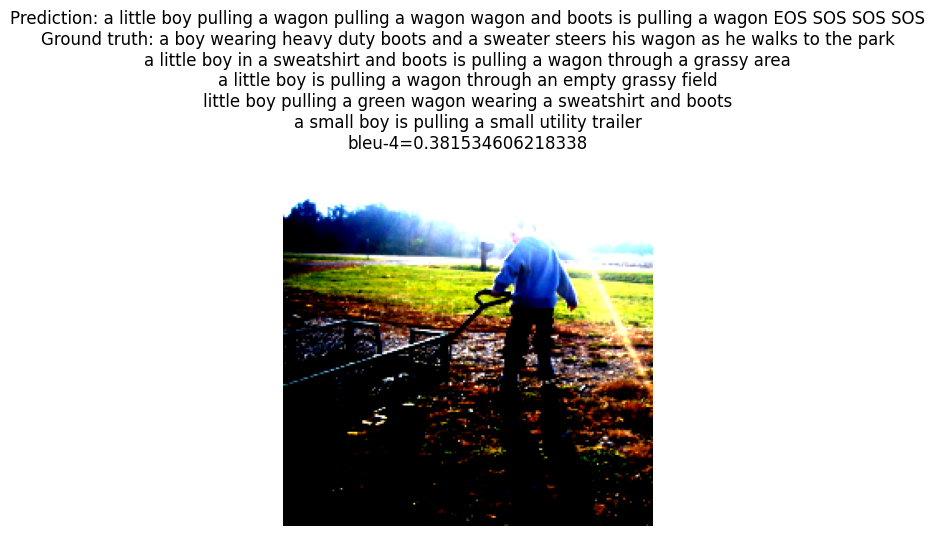

In [10]:
for image, decoded_sentence, ground_truth, bleu in sorted(zip(all_images, decoded_sentences, all_ground_truths_captions, bleu_scores), key=lambda x: x[3][3], reverse=True):
    display_image(image, decoded_sentence, ground_truth, bleu)
    break

In [19]:
model_settings = {
    'hidden_size': 512
}
decoder_settings = {
    'max_length': 20,
    'embedding_size': 512,
    'dropout_p': 0.2,
    'attention_type': 'Bahdanau'
}
encoder_settings = {
    'freeze_backbone': False
}
encoder = ImageEncoderAttention(
    **model_settings, **encoder_settings).to(device)
decoder = DecoderWithAttention(**model_settings, **decoder_settings,
                               output_size=test_dataset_modified.lang.n_words, device=device, encoder_dim=encoder.out_features).to(device)

load_checkpoint(encoder, decoder, None, None,
                os.path.join('weights', 'ImageEncoderAttention_DecoderWithAttention_Bahdanau_ckpt_2.pth'))
encoder = encoder.to(device)
decoder = decoder.to(device)
all_images, decoded_sentences, all_ground_truths_captions, bleu_scores = evaluate(
    encoder, decoder, test_dataloader_modified, 10)

Loaded checkpoint from epoch 2


  5%|▌         | 10/199 [00:08<02:33,  1.23it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


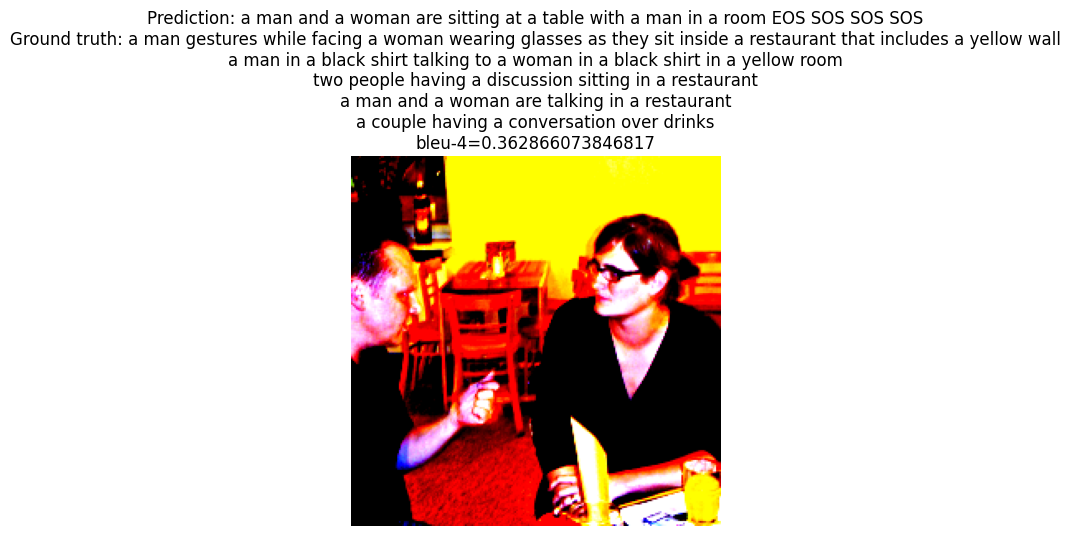

In [20]:
for image, decoded_sentence, ground_truth, bleu in sorted(zip(all_images, decoded_sentences, all_ground_truths_captions, bleu_scores), key=lambda x: x[3][3], reverse=True):
    display_image(image, decoded_sentence, ground_truth, bleu)
    break

In [13]:
model_settings = {
    'hidden_size': 512
}
decoder_settings = {
    'max_length': 20,
    'embedding_size': 512,
    'dropout_p': 0.2,
    'attention_type': 'Bahdanau'
}
encoder_settings = {
    'freeze_backbone': False,
    'nr_heads': 8
}
encoder = ImageEncoderAttention(
    **model_settings, **encoder_settings).to(device)
decoder = DecoderWithAttention(**model_settings, **decoder_settings,
                               output_size=test_dataset_modified.lang.n_words, device=device, encoder_dim=encoder.out_features).to(device)

load_checkpoint(encoder, decoder, None, None,
                os.path.join('weights', 'ImageEncoderAttention_8hAttn_DecoderWithAttention_Bahdanau_ckpt_2.pth'))
encoder = encoder.to(device)
decoder = decoder.to(device)
all_images, decoded_sentences, all_ground_truths_captions, bleu_scores = evaluate(
    encoder, decoder, test_dataloader_modified, 10)

Loaded checkpoint from epoch 2


  5%|▌         | 10/199 [00:09<02:52,  1.09it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


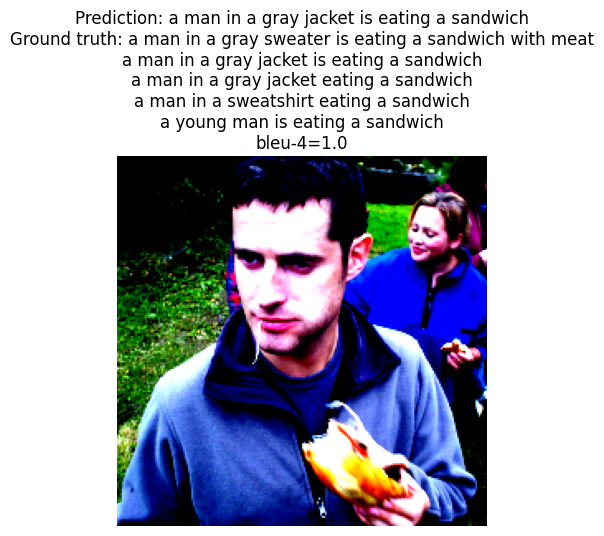

In [14]:
for image, decoded_sentence, ground_truth, bleu in sorted(zip(all_images, decoded_sentences, all_ground_truths_captions, bleu_scores), key=lambda x: x[3][3], reverse=True):
    display_image(image, decoded_sentence, ground_truth, bleu)
    break

In [17]:
model_settings = {
    'hidden_size': 512
}
decoder_settings = {
    'num_heads': 8,
    'num_layers': 6,
    'dropout_p': 0.2
}
encoder_settings = {
    'model_name': 'vit_base_patch16_224'
}
encoder = ViTImageEncoder(**encoder_settings).to(device)
decoder = ImageCaptioningModel(vocab_size=test_dataset.lang.n_words,
                               max_length=dataset_settings['max_length'], **decoder_settings, hidden_size=encoder.hidden_size, device=device).to(device)

load_checkpoint(encoder, decoder, None, None,
                os.path.join('weights', 'ViTImageEncoder_ImageCaptioningModel_ckpt.pth'))
encoder = encoder.to(device)
decoder = decoder.to(device)
all_images, decoded_sentences, all_ground_truths_captions, bleu_scores = evaluate(
    encoder, decoder, test_dataloader_modified, 10)

Loaded checkpoint from epoch 4


  5%|▌         | 10/199 [00:22<07:05,  2.25s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


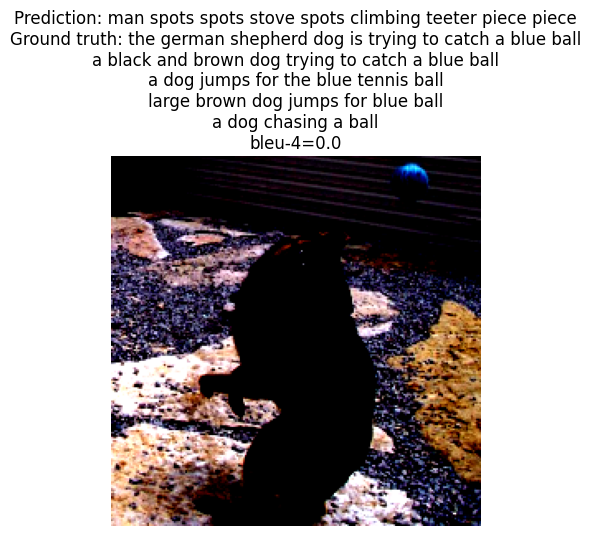

In [18]:
for image, decoded_sentence, ground_truth, bleu in sorted(zip(all_images, decoded_sentences, all_ground_truths_captions, bleu_scores), key=lambda x: x[3][3], reverse=True):
    display_image(image, decoded_sentence, ground_truth, bleu)
    break